In [1]:
# Data management
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Graphics
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modelling
# ------------------------------------------------------------------------------
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

from sklearn.metrics import accuracy_score
from sklearn import metrics 


# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
#warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('CSV_DEF_CLASIF.csv')
data.head()

,created_at,aid,extension,format,duration,FILE_STORED,FACIAL_ANALYSED,VOICE_ANALYSED,VOICE_TRANSCRIBED,BIOMETRICS_EXTRACTED,...,language,surprised_voice,no_speech_prob,entropy,tense_past,tense_present,tense_future,sentiment_polarity,sentiment_subjectivity,variable
0,1744824974,63612104-cc5c-4d54-b136-1f5880dece96,.mp4,video,NaN,True,True,False,True,False,...,en,NaN,0.006900,4.4125,0.3158,0.6842,0.0000,0.0932,0.5386,TDAH
1,1744825004,1afe2c00-8488-40f2-b3e1-5bd90fd57ad8,.mp4,video,213.0,True,True,True,True,True,...,en,0.043251,0.372388,4.3565,0.0769,0.9231,0.0000,0.2364,0.5069,TDAH
2,1744825017,6c987224-499c-469a-b908-dffef38c48b4,.mp4,video,115.0,True,True,True,True,True,...,es,0.190980,0.086458,4.1783,0.0000,1.0000,0.0000,0.3056,0.5162,Autismo
3,1744825025,e34d8573-7371-486a-900c-32a6ee78fabe,.mp4,video,202.0,True,True,True,True,True,...,es,0.006369,0.102629,4.2469,0.0833,0.7500,0.1667,0.2268,0.5349,Autismo
4,1744825037,5b442dc9-a39a-47e2-ba05-b0fe880ee44b,.mp4,video,135.0,True,True,True,True,True,...,es,0.047226,0.055492,4.2440,0.0833,0.9167,0.0000,0.2170,0.5825,Autismo


In [3]:
# Copia del dataframe original
df = data.copy()

# Columnas a eliminar (sin eliminar 'language')
cols_to_drop = [
    'created_at', 'aid', 'extension', 'format', 'duration',
    'FILE_STORED', 'FACIAL_ANALYSED', 'VOICE_ANALYSED', 'VOICE_TRANSCRIBED',
    'BIOMETRICS_EXTRACTED', 'SPEECH_ANALYSED', 'PERSONALITY_ANALYSED',
    'FACES_EXTRACTED', 'id'
]

# Eliminar columnas
df.drop(columns=cols_to_drop, inplace=True)

# Comprobación
print(f"Número de columnas tras la limpieza: {df.shape[1]}")
df.head()

Número de columnas tras la limpieza: 68


,angry_facial,disgust_facial,fear_facial,happy_facial,sad_facial,surprise_facial,neutral_facial,most_frequent_dominant_emotion,dominant_emotion_counts_surprise,average_face_confidence,...,language,surprised_voice,no_speech_prob,entropy,tense_past,tense_present,tense_future,sentiment_polarity,sentiment_subjectivity,variable
0,0.2098,0.0008,0.4117,0.1561,0.2053,0.0063,0.0099,sad,NaN,0.9500,...,en,NaN,0.006900,4.4125,0.3158,0.6842,0.0000,0.0932,0.5386,TDAH
1,0.0271,0.0000,0.1126,0.0005,0.6216,0.0001,0.2381,sad,NaN,0.9200,...,en,0.043251,0.372388,4.3565,0.0769,0.9231,0.0000,0.2364,0.5069,TDAH
2,0.1140,0.0000,0.1678,0.0062,0.4205,0.0020,0.2895,sad,NaN,0.9833,...,es,0.190980,0.086458,4.1783,0.0000,1.0000,0.0000,0.3056,0.5162,Autismo
3,0.0931,0.0771,0.1322,0.0408,0.3593,0.0007,0.2969,sad,NaN,0.9500,...,es,0.006369,0.102629,4.2469,0.0833,0.7500,0.1667,0.2268,0.5349,Autismo
4,0.0315,0.0001,0.0204,0.4411,0.2166,0.0009,0.2895,neutral,NaN,0.9167,...,es,0.047226,0.055492,4.2440,0.0833,0.9167,0.0000,0.2170,0.5825,Autismo


In [4]:
# Eliminar filas con clase 'Dispraxia'
df = df[df['variable'] != 'Dispraxia'].copy()

# Comprobación
print("Distribución de clases tras eliminar Dispraxia:")
print(df['variable'].value_counts())

Distribución de clases tras eliminar Dispraxia:
variable
Autismo     2093
Control     2033
TDAH        2030
Dislexia    2026
Name: count, dtype: int64


In [5]:
# Ver número de valores nulos por columna (ordenado)
df.isnull().sum().sort_values(ascending=False).head(20)

dominant_emotion_counts_surprise    7184
neutral_facial                       988
disgust_facial                       988
average_face_confidence              988
most_frequent_dominant_emotion       988
angry_facial                         988
surprise_facial                      988
sad_facial                           988
happy_facial                         988
fear_facial                          988
voice_kurtosis                       351
voice_median                         351
voice_mode                           351
voice_Q25                            351
voice_Q75                            351
voice_IQR                            351
voice_skewness                       351
voice_Q75_note                       351
voice_mean_note                      351
voice_median_note                    351
dtype: int64

In [6]:
print ("Tamaño del dataset:", df.shape)

Tamaño del dataset: (8182, 68)


In [7]:
# Eliminar columna con demasiados nulos
df.drop(columns=['dominant_emotion_counts_surprise'], inplace=True)

In [8]:
columnas_con_nulos = df.columns[df.isnull().any()].tolist()

# 3. Rellenar según el tipo de dato
for col in columnas_con_nulos:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
        print(f"ℹ️ Columna categórica '{col}' rellenada con su moda")

# 4. Comprobar que ya no quedan nulos
total_nulos = df.isnull().sum().sum()
print(f"\n✅ Nulos restantes tras limpieza: {total_nulos}")

ℹ️ Columna categórica 'most_frequent_dominant_emotion' rellenada con su moda
ℹ️ Columna categórica 'voice_mean_note' rellenada con su moda
ℹ️ Columna categórica 'voice_median_note' rellenada con su moda
ℹ️ Columna categórica 'voice_mode_note' rellenada con su moda
ℹ️ Columna categórica 'voice_Q25_note' rellenada con su moda
ℹ️ Columna categórica 'voice_Q75_note' rellenada con su moda
ℹ️ Columna categórica 'language' rellenada con su moda

✅ Nulos restantes tras limpieza: 0


In [9]:
print ("Tamaño del dataset después (para comprobar que no se eliminan filas):", df.shape)

Tamaño del dataset después (para comprobar que no se eliminan filas): (8182, 67)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 1. Separar X e y
X = df.drop(columns=['variable'])  # variable objetivo
y = df['variable']

# 2. Identificar columnas categóricas para codificar
columnas_categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Columnas categóricas a codificar:", columnas_categoricas)

# 3. Aplicar OneHotEncoding
X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

# 4. Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Comprobación final
print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)
print("Distribución de clases en y_train:\n", y_train.value_counts())

Columnas categóricas a codificar: ['most_frequent_dominant_emotion', 'voice_mean_note', 'voice_median_note', 'voice_mode_note', 'voice_Q25_note', 'voice_Q75_note', 'language']
Tamaño X_train: (6545, 179)
Tamaño X_test: (1637, 179)
Distribución de clases en y_train:
 variable
Autismo     1674
Control     1626
TDAH        1624
Dislexia    1621
Name: count, dtype: int64


In [11]:
# Librerías necesarias
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Pipeline con escalado + red neuronal
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42))
])

# Entrenamiento
mlp_pipeline.fit(X_train, y_train)

# Predicción
y_pred = mlp_pipeline.predict(X_test)

# Resultados
print(confusion_matrix(y_test, y_pred))
print("\n === Report === \n")
print(classification_report(y_test, y_pred))


[[318  31  29  41]
 [ 23 342  18  24]
 [  7   6 372  20]
 [ 23  16  13 354]]

 === Report === 

              precision    recall  f1-score   support

     Autismo       0.86      0.76      0.81       419
     Control       0.87      0.84      0.85       407
    Dislexia       0.86      0.92      0.89       405
        TDAH       0.81      0.87      0.84       406

    accuracy                           0.85      1637
   macro avg       0.85      0.85      0.85      1637
weighted avg       0.85      0.85      0.85      1637



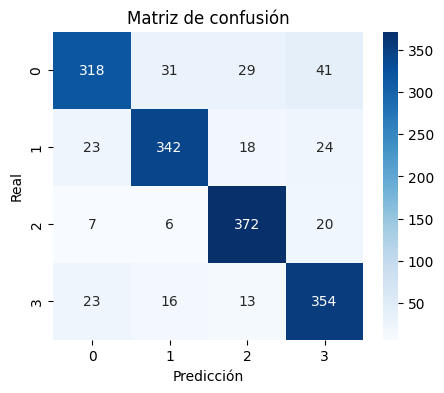

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

----

In [13]:
# Imports necesarios
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Crear pipeline
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42))
])

# Entrenar el modelo
mlp_pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, random_state=42))])

              precision    recall  f1-score   support

     Autismo       0.86      0.76      0.81       419
     Control       0.87      0.84      0.85       407
    Dislexia       0.86      0.92      0.89       405
        TDAH       0.81      0.87      0.84       406

    accuracy                           0.85      1637
   macro avg       0.85      0.85      0.85      1637
weighted avg       0.85      0.85      0.85      1637



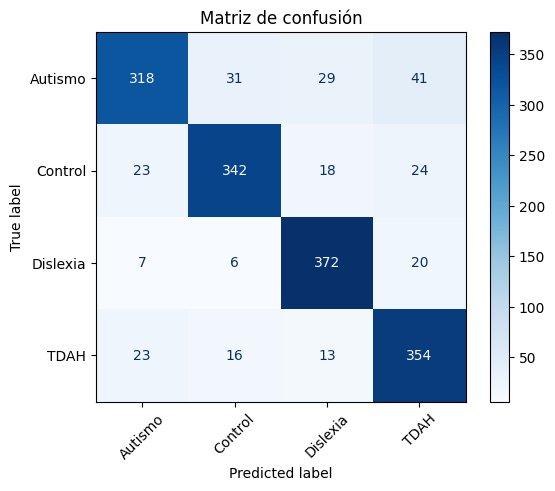

In [14]:
# Predicción
y_pred = mlp_pipeline.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión")
plt.show()


---
## GridSearchCV

Fitting 3 folds for each of 36 candidates, totalling 108 fits
✅ Mejores parámetros encontrados:
{'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.01}

🏆 Mejor accuracy en validación cruzada: 0.7332

=== Clasification Report (Test) ===
              precision    recall  f1-score   support

     Autismo       0.84      0.77      0.80       419
     Control       0.85      0.83      0.84       407
    Dislexia       0.84      0.92      0.88       405
        TDAH       0.83      0.83      0.83       406

    accuracy                           0.84      1637
   macro avg       0.84      0.84      0.84      1637
weighted avg       0.84      0.84      0.84      1637



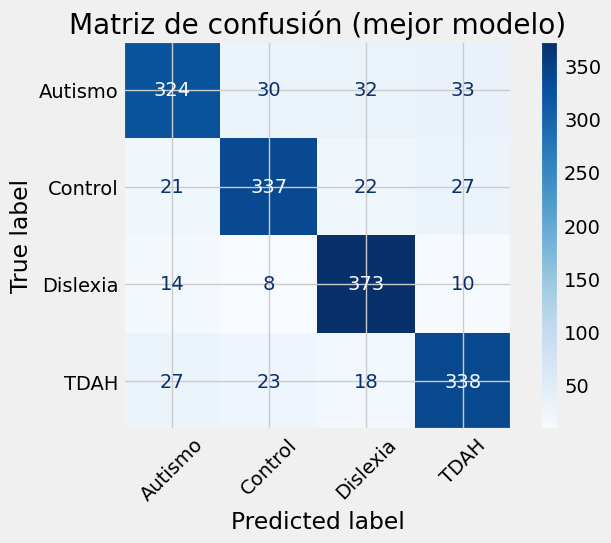

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# 1. Pipeline con preprocesado y MLP
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(max_iter=500, random_state=42))
])

# 2. Grid de hiperparámetros
param_grid = {
    "mlp__hidden_layer_sizes": [(100,), (100, 50), (50, 50)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [0.0001, 0.001, 0.01],
    "mlp__learning_rate_init": [0.001, 0.01]
}

# 3. GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

# 4. Resultados del tuning
print("✅ Mejores parámetros encontrados:")
print(grid.best_params_)
print("\n🏆 Mejor accuracy en validación cruzada:", round(grid.best_score_, 4))

# 5. Evaluación en test
y_pred = grid.predict(X_test)
print("\n=== Clasification Report (Test) ===")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión (mejor modelo)")
plt.show()


🧠 ¿Por qué ocurre esto?
El mejor modelo según validación cruzada (best_score_ = 0.7332) no garantiza que sea el mejor para el conjunto de test. La validación cruzada es una estimación, pero puede haber pequeñas variaciones.

Puede que el modelo base ya estuviera cerca del óptimo.

También puede influir la aleatoriedad del entrenamiento (aunque uses random_state=42).

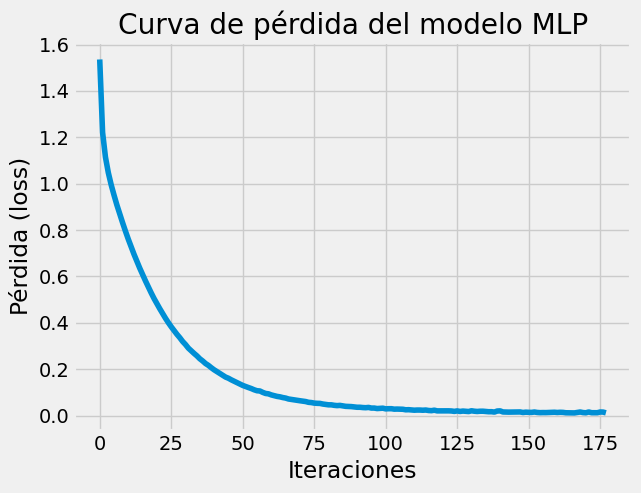

In [14]:
plt.plot(mlp_pipeline.named_steps["mlp"].loss_curve_)
plt.title("Curva de pérdida del modelo MLP")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida (loss)")
plt.grid(True)
plt.show()
